In [1]:
from model import HPE, HeatmapLoss, lr_scheduler
from data.dp import Dataset
import utils
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import cv2
import math

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# To solve "No algorithm worked!", run this codes.

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
model = HPE()

Model: "HPE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 128, 128, 64)    9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 128, 128, 64)    256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (1, 128, 128, 64)    0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [5]:
# checkpoint

checkpoint_path = "data/checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

model.save_weights(checkpoint_path.format(epoch=0))

In [6]:
config = {
    'data_provider': 'data.MPII.dp',
    'network': 'models.posenet.PoseNet',
    'inference': {
        'nstack': 8,
        'inp_dim': 256,
        'oup_dim': 16,
        'num_parts': 16,
        'increase': 0,
        'keys': ['imgs'],
        'num_eval': 2958, ## number of val examples used. entire set is 2958
        'train_num_eval': 300, ## number of train examples tested at test time
    },

    'train': {
        'batchsize': 16,
        'input_res': 256,
        'output_res': 64,
        'train_iters': 1000,
        'valid_iters': 10,
        'learning_rate': 1e-3,
        'max_num_people' : 1,
        'loss': [
            ['combined_hm_loss', 1],
        ],
        'decay_iters': 100000,
        'decay_lr': 2e-4,
        'num_workers': 2,
        'use_data_loader': True,
    },
}

In [7]:
t_ds = Dataset(config, 'train.h5')
v_ds = Dataset(config, 'valid.h5')
train = tf.data.Dataset.from_generator(t_ds.gen,
                                         output_types=(np.float32, np.float32),
                                         output_shapes=([None, 256, 256, 3], [None, 64, 64, 16]),
                                         args=())
valid = tf.data.Dataset.from_generator(v_ds.gen,
                                         output_types=(np.float32, np.float32),
                                         output_shapes=([None, 256, 256, 3], [None, 64, 64, 16]),
                                         args=())

loading data: annot
Done (t=2.68s)
loading data: annot
Done (t=0.36s)


In [8]:
lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
opt = tf.keras.optimizers.RMSprop(
    learning_rate=1e-04, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop')
model.compile(
    optimizer=opt, loss=HeatmapLoss, metrics=None, loss_weights=None,
    sample_weight_mode=None, weighted_metrics=None, target_tensors=None,
    distribute=None)
model.build((None, 256, 256, 3))

In [9]:
hist = model.fit(train, validation_data=valid, batch_size=16, callbacks=[lr, cp_callback], epochs=50)

Epoch 1/50
22246/22246 [==============================] - 2233s 100ms/step - loss: 0.0049 - val_loss: 6.6090e-04

Epoch 00001: saving model to data/checkpoint/cp-0001.ckpt
Epoch 2/50
22246/22246 [==============================] - 2174s 98ms/step - loss: 6.1921e-04 - val_loss: 6.5360e-04

Epoch 00002: saving model to data/checkpoint/cp-0002.ckpt
Epoch 3/50
22246/22246 [==============================] - 2187s 98ms/step - loss: 5.7254e-04 - val_loss: 6.4549e-04

Epoch 00003: saving model to data/checkpoint/cp-0003.ckpt
Epoch 4/50
22246/22246 [==============================] - 2166s 97ms/step - loss: 5.4371e-04 - val_loss: 6.3106e-04

Epoch 00004: saving model to data/checkpoint/cp-0004.ckpt
Epoch 5/50
22246/22246 [==============================] - 2165s 97ms/step - loss: 5.2142e-04 - val_loss: 6.0268e-04

Epoch 00005: saving model to data/checkpoint/cp-0005.ckpt
Epoch 6/50
22246/22246 [==============================] - 2162s 97ms/step - loss: 5.0569e-04 - val_loss: 5.9210e-04

Epoch 00006


Epoch 00047: saving model to data/checkpoint/cp-0047.ckpt
Epoch 48/50
22246/22246 [==============================] - 2160s 97ms/step - loss: 3.5590e-04 - val_loss: 5.5106e-04

Epoch 00048: saving model to data/checkpoint/cp-0048.ckpt
Epoch 49/50
22246/22246 [==============================] - 2164s 97ms/step - loss: 3.5550e-04 - val_loss: 5.5936e-04

Epoch 00049: saving model to data/checkpoint/cp-0049.ckpt
Epoch 50/50
22246/22246 [==============================] - 2160s 97ms/step - loss: 3.5752e-04 - val_loss: 5.5000e-04

Epoch 00050: saving model to data/checkpoint/cp-0050.ckpt


In [16]:
print(hist.history)

{'loss': [0.001219713594764471, 0.0006073222029954195, 0.0005656262510456145, 0.0005384073592722416, 0.000518474611453712, 0.0005032508634030819, 0.0004900816129520535, 0.0004793771367985755, 0.0004694635281339288, 0.0004612003976944834, 0.0004557402280624956, 0.0004486667749006301, 0.00044218802941031754, 0.00043736855150200427, 0.00043330955668352544, 0.0003876843547914177, 0.0003814317751675844, 0.0003793654032051563, 0.0003773964708670974, 0.00037547294050455093, 0.00037383398739621043, 0.0003724523994605988, 0.00037150635034777224, 0.00036991253728047013, 0.00036906354944221675, 0.00036797841312363744, 0.0003663919342216104, 0.00036563881440088153, 0.0003647161356639117, 0.0003640600189100951, 0.00035988487070426345, 0.00035981598193757236, 0.0003594760491978377, 0.0003596079768612981, 0.0003589591942727566, 0.0003586348029784858, 0.00035854082670994103, 0.00035892598680220544, 0.0003581973141990602, 0.0003581811033654958, 0.0003577971365302801, 0.0003571684064809233, 0.0003579546

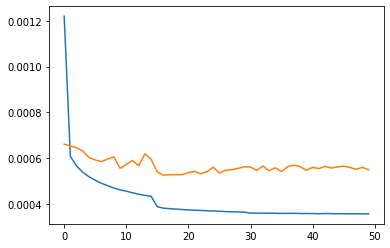

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.hi story['val_loss'])